# Overwatch Ult Charge

In [52]:
import collections
import itertools
import os.path
import pickle
import random
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from skimage import color
from skimage import data
from skimage import filters
from skimage import io
from skimage import transform

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MNIST_MODEL_LOC = 'mnist.h5'

Bbox = collections.namedtuple('Bbox', ['x','y','w','h'])

def crop_region(full_image, bbox):
    x, y, w, h = bbox
    return full_image[y:y+h, x:x+w]

dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'
imgfile = 'frame_05514.png'
valid_pkl = 'validation_dataset.pkl'

image = mpimg.imread(os.path.join(dirname, imgfile))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Display a random Overwatch frame

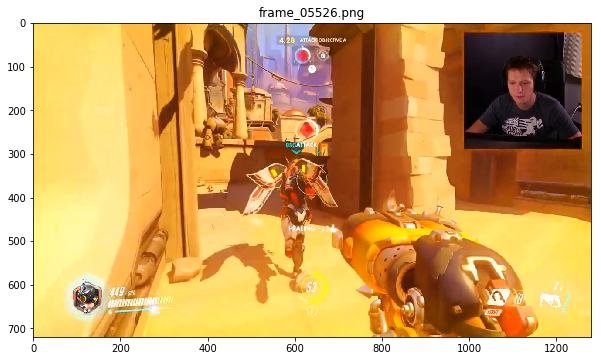

In [5]:
# Uncomment if you want a single image
# random.seed(231)

files = os.listdir(dirname)
imgfile = random.choice(files)
image = mpimg.imread(os.path.join(dirname, imgfile))

plt.imshow(image)
plt.title(imgfile)
plt.show()

# Display region containing Ult Charge

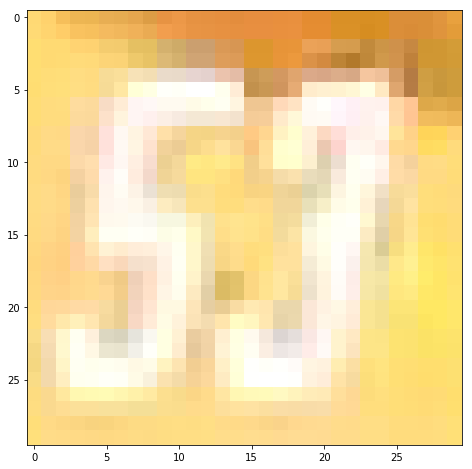

In [79]:
imgfile = 'frame_05514.png'

image = mpimg.imread(os.path.join(dirname, imgfile))
ult_bbox = Bbox(x=625, w=30, y=590, h=30)
plt.imshow(crop_region(image, ult_bbox))
plt.show()

# Train an MNIST model

In [11]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

if os.path.exists(MNIST_MODEL_LOC):
    model = load_model(MNIST_MODEL_LOC)
else:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save('mnist.h5')
    model.save_weights('mnist.weights.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.
/Users/ctang/miniconda3/envs/cs231n/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Test loss: 0.0297505717966
Test accuracy: 0.9897


# Display tens and ones digits

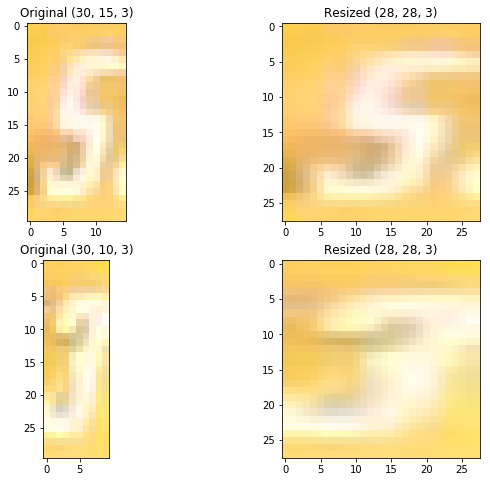

In [9]:
tens = crop_region(image, Bbox(x=625, y=590, w=15, h=30))
plt.subplot(2, 2, 1)
plt.imshow(tens)
plt.title("Original %s" % str(tens.shape))

tens_resized = cv2.resize(tens, (28, 28))
plt.subplot(2, 2, 2)
plt.imshow(tens_resized)
plt.title("Resized %s" % str(tens_resized.shape))

ones = crop_region(image, Bbox(x=640, y=590, w=10, h=30))
plt.subplot(2, 2, 3)
plt.imshow(ones)
plt.title("Original %s" % str(ones.shape))

ones_resized = cv2.resize(ones, (28, 28))
plt.subplot(2, 2, 4)
plt.imshow(ones_resized)
plt.title("Resized %s" % str(ones_resized.shape))

plt.show()

In [12]:
N, H, W, C = 1, 28, 28, 1
region = ones_resized[:,:,1].reshape(N, H, W, C)
result = model.predict(region)
print("actual=%d, predicted=%d" % (3, np.argmax(result)))

actual=3, predicted=3


# Prepare an evaluation dataset

In [13]:
dirname = '/Users/ctang/Documents/overwatch_object_detection/overwatch_part1_frames/smaller_dataset'

# Ult charge at 53%
start = 5474
end = 5541
fifty_three = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]

# Ult charge at 54%
start = 5542
end = 5574
fifty_four = [os.path.join(dirname, "frame_0%d.png" % i) for i in range(start, end+1)]

In [76]:
dataset_dirname = '/Users/ctang/dev/datasets/overwatch_digits'
prefix_5 = '5_'
prefix_4 = '4_'
prefix_3 = '3_'

tens_bbox = Bbox(x=625, y=590, w=15, h=30)
ones_bbox = Bbox(x=640, y=590, w=10, h=30)

if os.path.exists(valid_pkl):
    with open(valid_pkl, 'rb') as f:
        x_valid, y_valid = pickle.load(f)
        print('Deserialized validation dataset from Pickle file.')
else:
    x_valid = []
    y_valid = []

    for i, imgfile in tqdm.tqdm(enumerate(fifty_three)):
        five = crop_region(mpimg.imread(imgfile), tens_bbox)
        three = crop_region(mpimg.imread(imgfile), ones_bbox)

        x_valid.append(five)
        x_valid.append(three)
        y_valid.append(5)
        y_valid.append(3)
    print('Done producing 5 and 3 images.')

    for i, imgfile in tqdm.tqdm(enumerate(fifty_four)):
        five = crop_region(mpimg.imread(imgfile), tens_bbox)
        four = crop_region(mpimg.imread(imgfile), ones_bbox)

        x_valid.append(five)
        x_valid.append(four)
        y_valid.append(5)
        y_valid.append(4)
    print('Done producing 5 and 4 images.')
    
    with open(valid_pkl, 'wb') as f:
        pickle.dump((x_valid, y_valid), f)
        print('Done serializing validation dataset.')

Deserialized validation dataset from Pickle file.


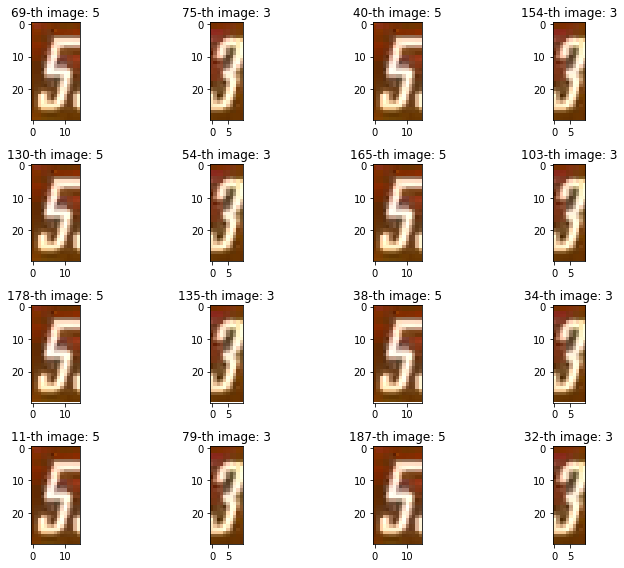

In [77]:
# Display a grid of labels + regions
for i, region in enumerate(random.sample(range(len(x_valid)), 16)):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_valid[i])
    plt.title("%d-th image: %d" % (region, y_valid[i]))

plt.tight_layout()
plt.show()

# Preparing image regions as input into a CNN

Convert the image regions from HxWx4 to 28x28x1.

In [78]:
x_valid_input = []
y_valid_input = np.array(y_valid)

for x in x_valid:
    warped = cv2.resize(x, (28, 28), interpolation=cv2.INTER_LINEAR)
    gray = color.rgb2gray(warped)
    x_valid_input.append(gray)

x_valid_input = np.array(x_valid_input)
print("Done")

Done


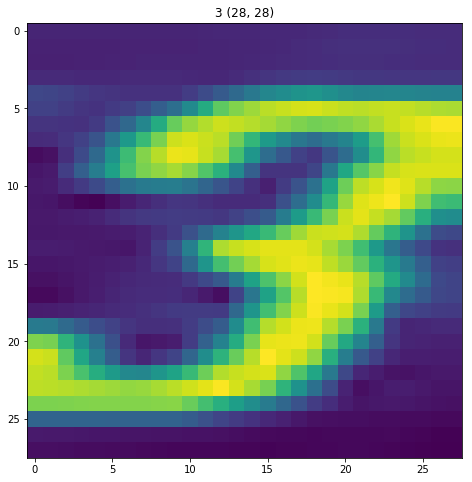

In [21]:
idx = random.randint(0, len(x_valid_input))
plt.imshow(x_valid_input[idx])
plt.title("%d %s" % (y_valid_input[idx], x_valid_input[idx].shape))
plt.show()

In [80]:
# plt.imshow needs either HxWx3 or HxW if C == 1
# so convert image from HxW to HxWx1 when ready for input into CNN
x_val = x_valid_input.reshape(len(x_valid_input), 28, 28, 1)
y_val = y_valid_input
y_val = keras.utils.to_categorical(y_val, num_classes)
score = model.evaluate(x_val, y_val, verbose=0)

with open('results_slanted.csv', 'w') as f:
    for i, pair in enumerate(zip(x_val, y_val)):
        x, y = pair
        actual = np.argmax(y)
        predicted = np.argmax(model.predict(x.reshape(1, 28, 28, 1)))
        f.write("[%d] actual=%d, predicted=%d\n" % (i, actual, predicted))

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.48412906651
Test accuracy: 0.584158415842


# Data Augmentation
## Synthetic Data
Since we're simply classifying the ult digits in Overwatch, we can generate more of them to create a training set.

Links:
* [HTML Color Picker](https://htmlcolorcodes.com/)
* [skimage shearing](http://scikit-image.org/docs/0.13.x/api/skimage.transform.html#skimage.transform.AffineTransform)
* [Converting np to PIL image](https://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap)
* [Drawing custom fonts](http://effbot.org/imagingbook/imagedraw.htm)
* [Drawing custom fonts 2](http://www.codesofinterest.com/2017/07/more-fonts-on-opencv.html)
* [How to shear an image](https://stackoverflow.com/questions/24191545/skewing-or-shearing-an-image-in-python)

Sheared in 0.000810 seconds.
Sheared in 0.000701 seconds.


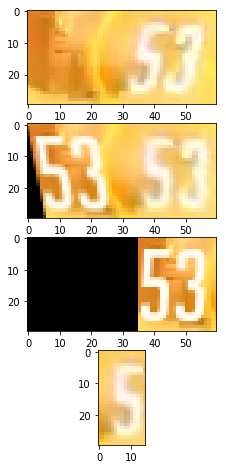

In [6]:
from PIL import ImageFont, ImageDraw, Image 

# tens = crop_region(image, Bbox(x=625, y=590, w=30, h=30))
space_tens = crop_region(image, Bbox(x=595, y=590, w=60, h=30))

# color palette
skin_color = (246, 233, 191)
lighter_skin_color = (252,241,202)
even_lighter = (255, 250, 235)

original_region = Image.fromarray(np.uint8(space_tens*255))
sheared_region = Image.fromarray(np.uint8(space_tens*255))
orig_sheared = Image.fromarray(np.uint8(space_tens*255))

draw = ImageDraw.Draw(sheared_region)
font = ImageFont.truetype("/Users/ctang/Downloads/bignoodletitling/big_noodle_titling_oblique.ttf", 32)
draw.text((0, -2), "53", font=font, fill=even_lighter)

draw2 = ImageDraw.Draw(orig_sheared)
font2 = ImageFont.truetype("/Users/ctang/Downloads/bignoodletitling/big_noodle_titling_oblique.ttf", 32)
draw2.text((0, -2), "53", font=font, fill=even_lighter)


affine_tf = transform.AffineTransform(shear=0.2, translation=(0, 0))

start = time.time()
sheared_region = transform.warp(sheared_region, inverse_map=affine_tf)
end = time.time()

print("Sheared in %f seconds." % (end - start))

translation_only = transform.AffineTransform(translation=(-35, 0))

start = time.time()
orig_sheared = transform.warp(orig_sheared, inverse_map=translation_only)
end = time.time()

print("Sheared in %f seconds." % (end - start))

nrows = 4
ncols = 1

plt.subplot(nrows, ncols, 1)
plt.imshow(original_region)
plt.subplot(nrows, ncols, 2)
plt.imshow(sheared_region)
plt.subplot(nrows, ncols, 3)
plt.imshow(orig_sheared)
plt.subplot(nrows, ncols, 4)

h, w, c = sheared_region.shape
sheared_region = crop_region(sheared_region, Bbox(x=w//2+2, y=0, w=w//4, h=h))
plt.imshow(sheared_region)
plt.show()

# Further Exploration
* Generate synthetic data
    * shear digits so that they're straight and not italic 
* Fine-tune on synthetic data
* Run eval on real data

actual=5, predicted=3


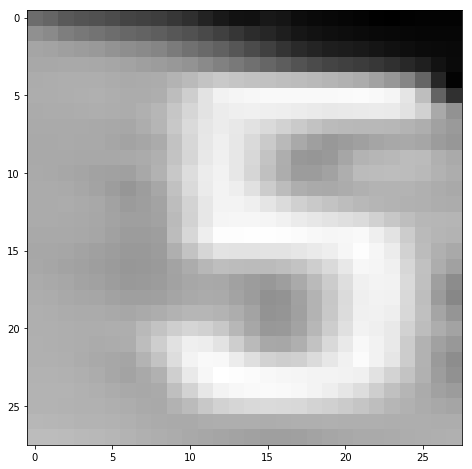

In [106]:
warped = cv2.resize(sheared_region, (28, 28), interpolation=cv2.INTER_LINEAR)
gray = color.rgb2gray(warped)
plt.imshow(gray, cmap='gray')
N, H, W, C = 1, 28, 28, 1
gray = gray.reshape(N, H, W, C)
result = model.predict(gray)
print("actual=%d, predicted=%d" % (5, np.argmax(result)))

# shear all validation images and run evaluation

In [59]:
ult_charge_bbox = Bbox(x=625, y=590, w=30, h=30)
shear = transform.AffineTransform(shear=0.2)

x_valid = []
y_valid = []

for imgfile in fifty_three:
    img = mpimg.imread(imgfile)
    region = crop_region(img, ult_charge_bbox)
    region = transform.warp(region, inverse_map=shear)
    five = cv2.resize(crop_region(region, Bbox(x=2, y=0, w=15, h=30)), (28, 28), interpolation=cv2.INTER_LINEAR)
    three = cv2.resize(crop_region(region, Bbox(x=17, y=0, w=15, h=30)), (28, 28), interpolation=cv2.INTER_LINEAR)
    five = color.rgb2gray(five)
    three = color.rgb2gray(three)
    x_valid.append(five)
    y_valid.append(5)
    x_valid.append(three)
    y_valid.append(3)

for imgfile in fifty_four:
    img = mpimg.imread(imgfile)
    region = crop_region(img, ult_charge_bbox)
    region = transform.warp(region, inverse_map=shear)
    five = cv2.resize(crop_region(region, Bbox(x=2, y=0, w=15, h=30)), (28, 28), interpolation=cv2.INTER_LINEAR)
    four = cv2.resize(crop_region(region, Bbox(x=17, y=0, w=15, h=30)), (28, 28), interpolation=cv2.INTER_LINEAR)
    five = color.rgb2gray(five)
    four = color.rgb2gray(four)
    x_valid.append(five)
    y_valid.append(5)
    x_valid.append(four)
    y_valid.append(4)

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_valid = x_valid.reshape(len(x_valid), 28, 28, 1)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
print(x_valid.shape)
print(y_valid.shape)

score = model.evaluate(x_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# nrows = 4
# ncols = 1

# plt.subplot(nrows, ncols, 1)
# plt.imshow(region)

# plt.subplot(nrows, ncols, 2)
# plt.imshow(crop_region(region, Bbox(x=2, y=0, w=15, h=30)))

# plt.subplot(nrows, ncols, 3)
# plt.imshow(crop_region(region, Bbox(x=17, y=0, w=15, h=30)))

# plt.subplot(nrows, ncols, 4)
# plt.imshow(gray, cmap='gray')

# plt.tight_layout()
# plt.show()

(202, 28, 28, 1)
(202, 10)
Test loss: 1.7640421544
Test accuracy: 0.589108910891


In [75]:
with open('results_sheared.csv', 'w') as f:
    for i, pair in enumerate(zip(x_valid, y_valid)):
        x, y = pair
        actual = np.argmax(y)
        predicted = np.argmax(model.predict(x.reshape(1, 28, 28, 1)))
        f.write("[%d] actual=%d, predicted=%d\n" % (i, actual, predicted))
print('Done')

Done
